## Multi Head Attention

**Multi-Head Attention** is the key mechanism inside Transformers that allows the model to attend to different parts of the input sequence simultaneously from multiple "perspectives."

Instead of computing a single attention function, the model:
1. **Splits** the Q, K, V vectors into multiple smaller "heads" (e.g., 8 heads of 64 dimensions each from a 512-dim vector).
2. Each head **independently** computes scaled dot-product attention.
3. The outputs of all heads are **concatenated** back into a single vector.
4. A **linear layer** mixes information across heads to produce the final output.

**Why multiple heads?** A single attention head might focus on one type of relationship (e.g., syntactic). Multiple heads can capture different types of relationships simultaneously (syntactic, semantic, positional, etc.).

In [ ]:
# -------------------------------------------------------------------
# Import libraries
# -------------------------------------------------------------------
import numpy as np               # For numerical operations (used in histogram plotting)
import torch                     # PyTorch — the deep learning framework
import torch.nn as nn            # Neural network modules (Linear layers, etc.)
import torch.nn.functional as F  # Functional API — contains softmax, relu, etc.

In [ ]:
# -------------------------------------------------------------------
# Define input dimensions and create a random input tensor
# -------------------------------------------------------------------
# sequence_length = 4  → Number of tokens/words in the input sentence
#                        Example: "my name is Aj" → 4 tokens
# batch_size = 1       → Processing 1 sentence at a time
#                        (In real training, batch_size is larger, e.g., 32 or 64)
# input_dim = 512      → Dimension of each input word embedding
#                        (Each word is represented as a 512-dimensional vector)
# d_model = 512        → Internal model dimension (the Transformer's working dimension)
#                        Often same as input_dim, but can differ
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512

# Create a random input tensor to simulate word embeddings
# Shape: (batch_size, sequence_length, input_dim) = (1, 4, 512)
#   - Dimension 0: batch (1 sentence)
#   - Dimension 1: sequence (4 words)
#   - Dimension 2: embedding (512-dim vector per word)
# In a real Transformer, this would come from an embedding layer + positional encoding
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [ ]:
# Verify the input shape: should be (1, 4, 512)
# (batch_size=1, sequence_length=4, input_dim=512)
x.size()

torch.Size([1, 4, 512])

In [ ]:
# -------------------------------------------------------------------
# Create a single linear layer to generate Q, K, V all at once
# -------------------------------------------------------------------
# Instead of 3 separate linear layers (one each for Q, K, V), we use ONE linear
# layer that outputs 3× the model dimension. This is more efficient!
#
# nn.Linear(input_dim, 3 * d_model) = nn.Linear(512, 1536)
#   - Input:  512-dim vector per word
#   - Output: 1536-dim vector per word (which we'll split into Q, K, V later)
#   - The 1536 = 3 × 512 → first 512 dims = Q, next 512 = K, last 512 = V
#
# This layer contains a learned weight matrix W of shape (512, 1536) + bias (1536)
# Each word's embedding is multiplied by this weight matrix to produce its Q, K, V
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [ ]:
# -------------------------------------------------------------------
# Pass the input through the QKV linear layer
# -------------------------------------------------------------------
# x shape:   (1, 4, 512)  → 1 batch, 4 words, 512-dim each
# qkv shape: (1, 4, 1536) → 1 batch, 4 words, 1536-dim each
#
# For each word, the 1536-dim output contains:
#   [0:512]    = Query vector  (what this word is looking for)
#   [512:1024] = Key vector    (what this word offers for matching)
#   [1024:1536]= Value vector  (the actual information this word carries)
qkv = qkv_layer(x)

In [ ]:
# Verify QKV shape: should be (1, 4, 1536)
# 1536 = 3 × 512  (concatenated Q, K, V for each word)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

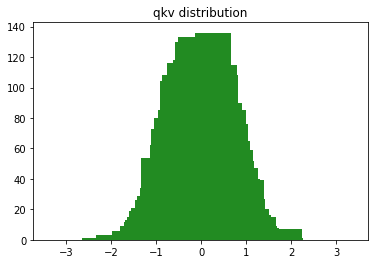

In [ ]:
# -------------------------------------------------------------------
# Visualize the distribution of QKV values
# -------------------------------------------------------------------
# After the linear layer, the QKV values should roughly follow a normal distribution
# (since our input was random normal and the linear layer has random weights)
# This histogram helps verify that values are well-distributed and not saturated
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)  # Count values in 200 bins from -3 to 3
x_val = np.arange(-1, 1, 0.01) * 3                  # X-axis values: -3 to 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')
# A roughly bell-shaped curve centered near 0 is expected and healthy

In [ ]:
# -------------------------------------------------------------------
# Reshape QKV to separate attention heads
# -------------------------------------------------------------------
# We want to split the 1536-dim QKV into 8 heads, each handling 64 dims for Q, K, V
#
# num_heads = 8   → 8 parallel attention heads
# head_dim = 512 // 8 = 64  → each head works on 64-dimensional slices
#
# Reshape: (1, 4, 1536) → (1, 4, 8, 192)
#   - batch_size=1, sequence_length=4, num_heads=8, 3*head_dim=192
#   - 192 = 3 × 64 (Q + K + V per head, each 64-dim)
#   - This groups the QKV values by head so each head gets its own slice
num_heads = 8
head_dim = d_model // num_heads  # 512 / 8 = 64 dimensions per head
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [ ]:
# Verify shape after reshape: should be (1, 4, 8, 192)
# (batch=1, seq_len=4, heads=8, 3×head_dim=192)
qkv.shape

torch.Size([1, 4, 8, 192])

In [ ]:
# -------------------------------------------------------------------
# Permute dimensions to bring num_heads before sequence_length
# -------------------------------------------------------------------
# Before: (batch_size, sequence_length, num_heads, 3*head_dim) = (1, 4, 8, 192)
# After:  (batch_size, num_heads, sequence_length, 3*head_dim) = (1, 8, 4, 192)
#
# WHY? We want each head to independently process ALL words in the sequence.
# By putting num_heads in dimension 1, we can treat each head as if it were
# a separate "mini batch" — matrix operations along the last two dims will
# compute attention for each head independently and in parallel.
#
# Think of it as: 8 independent attention computations, each seeing all 4 words
qkv = qkv.permute(0, 2, 1, 3)  # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [ ]:
# -------------------------------------------------------------------
# Split the combined QKV tensor into separate Q, K, V tensors
# -------------------------------------------------------------------
# qkv shape: (1, 8, 4, 192)  — last dim = 192 = 3 × 64 (Q+K+V concatenated)
#
# .chunk(3, dim=-1) splits the last dimension into 3 equal parts:
#   q shape: (1, 8, 4, 64)  → Query vectors: "What am I looking for?"
#   k shape: (1, 8, 4, 64)  → Key vectors:   "What do I contain?"
#   v shape: (1, 8, 4, 64)  → Value vectors:  "What information do I carry?"
#
# Each head now has its own independent set of 64-dim Q, K, V for all 4 words
# Head 0 might learn to attend to syntactic structure
# Head 1 might learn to attend to semantic meaning
# Head 2 might learn to attend to positional proximity, etc.
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### Summary of tensor transformations so far:

| Step | Shape | Description |
|------|-------|-------------|
| Input `x` | (1, 4, 512) | 1 batch, 4 words, 512-dim embeddings |
| After QKV linear | (1, 4, 1536) | Q+K+V concatenated (3 × 512) |
| After reshape | (1, 4, 8, 192) | Split into 8 heads (3 × 64 per head) |
| After permute | (1, 8, 4, 192) | Heads moved to dim 1 for parallel attention |
| After chunk | 3 × (1, 8, 4, 64) | Separate Q, K, V — each head has 64-dim vectors |

## Self Attention for multiple heads

For a single head, the scaled dot-product attention formula is:

$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$

**Key difference from single-head attention:** Here Q, K, V are **per-head** (64-dim each), not the full 512-dim. Each of the 8 heads computes this formula independently on its own 64-dim slice. PyTorch handles all 8 heads in parallel via batch dimensions.

In [ ]:
# -------------------------------------------------------------------
# Compute scaled attention scores: Q · K^T / √d_k
# -------------------------------------------------------------------
import math

# d_k = dimension of each head's key/query vector = 64
d_k = q.size()[-1]

# Matrix multiplication of Q and K^T:
#   q shape:                (1, 8, 4, 64)
#   k.transpose(-2, -1):   (1, 8, 64, 4)  — swap last two dims to get K^T
#   Result (scaled):        (1, 8, 4, 4)   — attention scores for each head
#
# For each head: a 4×4 matrix where entry [i,j] = how much word i attends to word j
# We divide by √d_k = √64 = 8 to stabilize the variance (prevents softmax saturation)
#
# Note: .transpose(-2, -1) swaps the last two dimensions.
#   This is equivalent to transposing the (seq_len × head_dim) matrix for each head.
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

# Result: (1, 8, 4, 4) → 1 batch, 8 heads, each with a 4×4 attention score matrix
scaled.shape

torch.Size([1, 8, 4, 4])

In [ ]:
# -------------------------------------------------------------------
# Why NOT use k.T for transpose? Let's see why:
# -------------------------------------------------------------------
# k.T transposes ALL dimensions (reverses the order of all dims):
#   k shape:     (1, 8, 4, 64)
#   k.T shape:   (64, 4, 8, 1)  ← This reverses ALL 4 dimensions!
#
# But we ONLY want to transpose the last two dims (4, 64) → (64, 4)
# while keeping batch and head dims unchanged.
# That's why we use k.transpose(-2, -1) which ONLY swaps dims -2 and -1:
#   k.transpose(-2, -1) shape: (1, 8, 64, 4)  ← Correct!
k.T.shape  # (64, 4, 8, 1) — WRONG for our purposes!

torch.Size([64, 4, 8, 1])

In [ ]:
# -------------------------------------------------------------------
# Quick demo: torch.transpose() swaps exactly TWO specified dimensions
# -------------------------------------------------------------------
# For a 2D tensor, transpose(0,1) and transpose(1,0) are identical — 
# both swap rows and columns (like a regular matrix transpose)
y = torch.randn(2, 3)            # 2×3 matrix
torch.transpose(y, 0, 1)          # → 3×2 matrix (swap dim 0 and dim 1)

tensor([[-0.4146,  1.1240],
        [-0.0925,  0.0419],
        [-1.1873,  0.4655]])

In [ ]:
# Same result — order of arguments doesn't matter for 2D tensors
# transpose(1, 0) == transpose(0, 1) for 2D tensors
torch.transpose(y, 1, 0)

tensor([[-0.4146,  1.1240],
        [-0.0925,  0.0419],
        [-1.1873,  0.4655]])

In [ ]:
# -------------------------------------------------------------------
# Verify: transpose(-1, -2) == transpose(-2, -1) for our K tensor
# -------------------------------------------------------------------
# Negative indexing: -1 = last dim, -2 = second-to-last dim
# Both swap the same pair of dimensions, so the result is identical
# This confirms that the order of the two dimension arguments doesn't matter
k.transpose(-1, -2) == k.transpose(-2, -1)  # All True

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [ ]:
# Correct transposed K shape: (1, 8, 64, 4)
# Batch(1) and heads(8) are untouched; only seq_len(4) and head_dim(64) are swapped
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [ ]:
# -------------------------------------------------------------------
# Create the causal (look-ahead) mask for the DECODER
# -------------------------------------------------------------------
# Purpose: Prevent each word from attending to FUTURE words during decoding.
#
# Step 1: Create a matrix filled with -infinity, same size as the attention scores
#   torch.full(scaled.size(), float('-inf')) → shape (1, 8, 4, 4), all values = -inf
#
# Step 2: torch.triu(mask, diagonal=1) keeps only the UPPER triangle (above the diagonal)
#   - diagonal=1 means: keep elements ABOVE the main diagonal (exclude diagonal itself)
#   - Elements on and below the diagonal become 0
#
# Result for each head's 4×4 mask:
#   [[  0, -inf, -inf, -inf],    ← word 0: can only see itself
#    [  0,    0, -inf, -inf],    ← word 1: can see words 0-1
#    [  0,    0,    0, -inf],    ← word 2: can see words 0-2
#    [  0,    0,    0,    0]]    ← word 3: can see all words 0-3
#
# When added to attention scores:
#   0 entries → score unchanged (allowed to attend)
#   -inf entries → score becomes -inf → softmax(-inf) = 0 (blocked)
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)

# Display the mask for head 1 (index 1) — all heads share the same mask pattern
mask[0][1]  # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [ ]:
# -------------------------------------------------------------------
# Preview: what do the masked attention scores look like for head 0, word 0?
# -------------------------------------------------------------------
# (scaled + mask)[0][0] = batch 0, head 0
# For word 0 (first row): only [0,0] has a real score, rest are -inf
# This ensures word 0 can ONLY attend to itself during decoding
(scaled + mask)[0][0]

tensor([[-0.0611,    -inf,    -inf,    -inf],
        [ 0.5596,  0.0404,    -inf,    -inf],
        [ 0.1348, -0.0516,  0.3945,    -inf],
        [ 0.0038,  0.5560, -0.2397,  0.4025]], grad_fn=<SelectBackward0>)

In [ ]:
# -------------------------------------------------------------------
# Apply the mask to the scaled attention scores (in-place addition)
# -------------------------------------------------------------------
# scaled shape: (1, 8, 4, 4) — attention scores for each head
# mask shape:   (1, 8, 4, 4) — 0 for allowed, -inf for blocked
#
# After this: future positions have -inf scores → softmax will zero them out
# Note: += modifies scaled in-place (no new tensor created)
scaled += mask

In [ ]:
# -------------------------------------------------------------------
# Quick softmax sanity check with actual numbers
# -------------------------------------------------------------------
# If we have two scores: 0.5596 and 0.0404, softmax should give:
#   softmax(0.5596) = e^0.5596 / (e^0.5596 + e^0.0404)
#
# This verifies our understanding: the higher score (0.5596) gets a LARGER
# probability weight. Softmax converts raw scores into a probability distribution
# where all values are between 0 and 1, and they sum to 1.
np.exp(0.5596) / (np.exp(0.5596) + np.exp(0.0404))  # Should be ~0.63

0.6269606805367254

In [ ]:
# -------------------------------------------------------------------
# Apply softmax to get attention weights (probability distributions)
# -------------------------------------------------------------------
# F.softmax(scaled, dim=-1):
#   - Applies softmax along the LAST dimension (dim=-1 = across columns)
#   - Each row becomes a probability distribution summing to 1.0
#   - Entries that were -inf become 0 probability (masked future words!)
#
# Input:  scaled shape (1, 8, 4, 4) — raw masked scores
# Output: attention shape (1, 8, 4, 4) — probability weights
#
# For each head, each word (row) now has a probability distribution over
# all words it's allowed to attend to.
# Example row for word 2: [0.15, 0.25, 0.60, 0.00]
#   → 15% attention to word 0, 25% to word 1, 60% to itself, 0% to word 3 (masked)
attention = F.softmax(scaled, dim=-1)

In [ ]:
# Attention shape: (1, 8, 4, 4)
# (batch=1, heads=8, seq_len=4, seq_len=4)
# Each head has its own 4×4 attention weight matrix
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
# -------------------------------------------------------------------
# View attention weights for batch 0, head 0
# -------------------------------------------------------------------
# This 4×4 matrix shows how head 0 distributes attention:
#   Row 0: word 0's attention → [prob, 0, 0, 0]     (only sees itself)
#   Row 1: word 1's attention → [prob, prob, 0, 0]   (sees words 0-1)
#   Row 2: word 2's attention → [prob, prob, prob, 0] (sees words 0-2)
#   Row 3: word 3's attention → [prob, prob, prob, prob] (sees all words)
#
# Notice: upper triangle is 0 (masked!) and each row sums to 1.0
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6270, 0.3730, 0.0000, 0.0000],
        [0.3198, 0.2655, 0.4147, 0.0000],
        [0.1996, 0.3467, 0.1564, 0.2973]], grad_fn=<SelectBackward0>)

In [ ]:
# -------------------------------------------------------------------
# Compute new context-aware Value vectors: attention · V
# -------------------------------------------------------------------
# Matrix multiplication: attention weights × value vectors
#   attention shape: (1, 8, 4, 4)  — how much each word attends to others
#   v shape:         (1, 8, 4, 64) — original value vectors per head
#   Result:          (1, 8, 4, 64) — new context-enriched value vectors per head
#
# For each head and each word i:
#   values[i] = Σ_j attention[i][j] × v[j]
#   = weighted sum of ALL value vectors, using attention probabilities as weights
#
# This is the KEY step: each word's output now contains information from
# the words it attended to, weighted by how relevant they are!
values = torch.matmul(attention, v)
values.shape  # (1, 8, 4, 64) — 8 heads, each producing 64-dim output per word

torch.Size([1, 8, 4, 64])

## Function

Encapsulate the scaled dot-product attention into a reusable function.
This function handles both **encoder** (no mask → full bidirectional attention) and **decoder** (with mask → causal attention) cases.

In [ ]:
import math

def scaled_dot_product(q, k, v, mask=None):
    """
    Compute Scaled Dot-Product Attention (works for all heads in parallel).
    
    Formula: Attention(Q, K, V) = softmax( Q·K^T / √d_k + mask ) · V
    
    Args:
        q:    Query tensor  — shape (batch, num_heads, seq_len, head_dim)
        k:    Key tensor    — shape (batch, num_heads, seq_len, head_dim)
        v:    Value tensor  — shape (batch, num_heads, seq_len, head_dim)
        mask: Optional causal mask — shape (batch, num_heads, seq_len, seq_len)
              - 0 for allowed positions, -inf for blocked (future) positions
              - Pass None for encoder (no masking needed)
              - Pass triangular mask for decoder (prevent future peeking)
    
    Returns:
        values:    Context-enriched output — shape (batch, num_heads, seq_len, head_dim)
        attention: Attention weights       — shape (batch, num_heads, seq_len, seq_len)
    """
    # Step 1: Get d_k from the last dimension of Q
    d_k = q.size()[-1]  # head_dim (e.g., 64)
    
    # Step 2: Compute Q·K^T / √d_k → scaled attention scores
    # q @ k^T → (batch, heads, seq, seq) — pairwise attention scores
    # Dividing by √d_k stabilizes gradients (prevents softmax saturation)
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    
    # Step 3: Apply mask (only for decoder — blocks future token attention)
    if mask is not None:
        scaled += mask  # -inf scores → 0 probability after softmax
    
    # Step 4: Softmax → convert scores to probability distribution per row
    attention = F.softmax(scaled, dim=-1)  # Each row sums to 1.0
    
    # Step 5: Weighted sum of value vectors using attention weights
    values = torch.matmul(attention, v)  # (batch, heads, seq, head_dim)
    
    return values, attention

In [ ]:
# -------------------------------------------------------------------
# Run the attention function with our Q, K, V and mask
# -------------------------------------------------------------------
# This computes attention for all 8 heads simultaneously in one call!
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [ ]:
# Attention shape: (1, 8, 4, 4)
# Each of 8 heads has its own 4×4 attention weight matrix
attention.shape

torch.Size([1, 8, 4, 4])

In [ ]:
# View attention weights for batch 0, head 0
# Lower triangle has probabilities, upper triangle is 0 (masked)
# Each row sums to 1.0
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6270, 0.3730, 0.0000, 0.0000],
        [0.3198, 0.2655, 0.4147, 0.0000],
        [0.1996, 0.3467, 0.1564, 0.2973]], grad_fn=<SelectBackward0>)

In [ ]:
# Values shape: (1, 8, 4, 64)
# 8 heads × 4 words × 64-dim output per head
# These are the new context-aware representations — but still separated by head
values.size()

torch.Size([1, 8, 4, 64])

In [ ]:
# -------------------------------------------------------------------
# Concatenate all heads back into a single vector per word
# -------------------------------------------------------------------
# Current shape: (1, 8, 4, 64) → (batch, heads, seq_len, head_dim)
# Target shape:  (1, 4, 512)   → (batch, seq_len, d_model)
#
# Reshape merges num_heads × head_dim = 8 × 64 = 512 back into one dimension
# This concatenates the outputs from all 8 heads for each word
# Now each word has a single 512-dim vector that captures ALL heads' perspectives
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()  # (1, 4, 512)

torch.Size([1, 4, 512])

In [ ]:
# -------------------------------------------------------------------
# Final linear layer: mix information ACROSS attention heads
# -------------------------------------------------------------------
# nn.Linear(d_model, d_model) = nn.Linear(512, 512)
#
# WHY do we need this?
# After concatenation, each 64-dim chunk only contains info from ONE head.
# The heads haven't "talked" to each other yet!
# This linear layer applies a learned weight matrix W_O (512 × 512) that
# allows the model to combine information from ALL heads into a final output.
#
# This is the W_O matrix from the paper: MultiHead(Q,K,V) = Concat(head_1,...,head_h) × W_O
linear_layer = nn.Linear(d_model, d_model)

In [ ]:
# -------------------------------------------------------------------
# Pass concatenated values through the linear layer
# -------------------------------------------------------------------
# Input:  (1, 4, 512) — concatenated head outputs
# Output: (1, 4, 512) — final multi-head attention output
# Each word now has a 512-dim vector that encodes:
#   ✓ Context from all other words (via attention)
#   ✓ Multiple perspectives (via 8 different heads)
#   ✓ Cross-head information mixing (via this linear layer)
out = linear_layer(values)

In [ ]:
# Final output shape: (1, 4, 512)
# Same shape as the input! This is by design — multi-head attention
# is a "context enrichment" operation that preserves dimensionality
# so it can be stacked in multiple layers
out.shape

torch.Size([1, 4, 512])

In [ ]:
# Display the actual output values
# Each of the 4 words now has a 512-dim context-enriched representation
# These would next be passed to Add & Norm → Feed Forward → etc. in the Transformer
out

tensor([[[ 0.0687,  0.0984,  0.0381,  ...,  0.1252,  0.0707, -0.0547],
         [-0.0399,  0.0419, -0.0933,  ...,  0.3064,  0.1585,  0.0599],
         [-0.0684, -0.0657,  0.2306,  ...,  0.0606,  0.0670,  0.0293],
         [ 0.0781, -0.0159, -0.0343,  ...,  0.0074, -0.1094, -0.0365]]],
       grad_fn=<ViewBackward0>)

## Class

Encapsulate the **entire multi-head attention mechanism** into a reusable `nn.Module` class. This bundles together:
1. The QKV projection (linear layer)
2. Reshaping into multiple heads
3. Scaled dot-product attention (per head)
4. Concatenation of heads
5. Output linear projection (cross-head mixing)

This class can be used as a drop-in component in both the **encoder** and **decoder** of a Transformer.

In [ ]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    """
    Compute Scaled Dot-Product Attention for all heads in parallel.
    (Same function as defined above, included here for self-contained class)
    """
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):
    """
    Multi-Head Attention module for Transformer neural networks.
    
    This implements the full multi-head attention mechanism:
        MultiHead(Q, K, V) = Concat(head_1, ..., head_h) · W_O
    
    where each head_i = Attention(Q·W_Q_i, K·W_K_i, V·W_V_i)
    
    Architecture:
        Input (batch, seq_len, input_dim)
          → QKV Linear Layer → (batch, seq_len, 3 * d_model)
          → Reshape & Split into heads → Q, K, V each (batch, num_heads, seq_len, head_dim)
          → Scaled Dot-Product Attention per head → (batch, num_heads, seq_len, head_dim)
          → Concatenate heads → (batch, seq_len, d_model)
          → Output Linear Layer → (batch, seq_len, d_model)
    """

    def __init__(self, input_dim, d_model, num_heads):
        """
        Args:
            input_dim:  Dimension of input word embeddings (e.g., 512 or 1024)
            d_model:    Internal model dimension (typically 512)
            num_heads:  Number of parallel attention heads (typically 8)
                        d_model must be divisible by num_heads
        """
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads  # e.g., 512 // 8 = 64 per head
        
        # Single linear layer to produce Q, K, V all at once (more efficient!)
        # Maps: input_dim → 3 * d_model (e.g., 512 → 1536)
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        
        # Output linear layer: mixes information across all attention heads
        # Maps: d_model → d_model (e.g., 512 → 512)
        # This is the W_O matrix from the "Attention Is All You Need" paper
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        """
        Forward pass of Multi-Head Attention.
        
        Args:
            x:    Input tensor — shape (batch_size, sequence_length, input_dim)
            mask: Optional causal mask — shape matching (batch, heads, seq, seq)
        
        Returns:
            out:  Context-enriched output — shape (batch_size, sequence_length, d_model)
        """
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        # x: (batch, seq_len, input_dim) e.g., (30, 5, 1024)
        
        # ---- Step 1: Project input to Q, K, V ----
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        # qkv: (batch, seq_len, 3*d_model) e.g., (30, 5, 1536)
        
        # ---- Step 2: Reshape to separate heads ----
        # Split the 3*d_model dimension into num_heads groups of 3*head_dim
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        # qkv: (batch, seq_len, num_heads, 3*head_dim) e.g., (30, 5, 8, 192)
        
        # ---- Step 3: Move heads dimension before sequence ----
        # So each head can independently process the full sequence
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        # qkv: (batch, num_heads, seq_len, 3*head_dim) e.g., (30, 8, 5, 192)
        
        # ---- Step 4: Split into separate Q, K, V tensors ----
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        # q, k, v: each (batch, num_heads, seq_len, head_dim) e.g., (30, 8, 5, 64)
        
        # ---- Step 5: Compute scaled dot-product attention for ALL heads ----
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        # values: (batch, num_heads, seq_len, head_dim) e.g., (30, 8, 5, 64)
        # attention: (batch, num_heads, seq_len, seq_len) e.g., (30, 8, 5, 5)
        
        # ---- Step 6: Concatenate all heads back together ----
        # Merge num_heads × head_dim = 8 × 64 = 512 back into d_model
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        # values: (batch, seq_len, d_model) e.g., (30, 5, 512)
        
        # ---- Step 7: Final linear projection (W_O) ----
        # This allows cross-head communication and produces the final output
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        # out: (batch, seq_len, d_model) e.g., (30, 5, 512)
        
        return out

## Input & Testing

Test the `MultiheadAttention` class with a larger, more realistic input to verify it handles different batch sizes, sequence lengths, and input dimensions correctly.

In [ ]:
# -------------------------------------------------------------------
# Test the MultiheadAttention class with realistic parameters
# -------------------------------------------------------------------
# input_dim = 1024       → Input embeddings have 1024 dimensions
#                          (This can differ from d_model; the QKV layer handles the projection)
# d_model = 512          → Internal Transformer dimension (from "Attention Is All You Need")
# num_heads = 8          → 8 parallel attention heads (512 / 8 = 64 dims per head)
#
# batch_size = 30        → Process 30 sentences simultaneously (realistic training batch)
# sequence_length = 5    → Each sentence has 5 tokens
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5

# Create random input: 30 sentences × 5 words × 1024-dim embeddings
x = torch.randn( (batch_size, sequence_length, input_dim) )

# Instantiate the MultiheadAttention module
# This creates all the learned weight matrices (QKV projection + output projection)
model = MultiheadAttention(input_dim, d_model, num_heads)

# Forward pass: transforms (30, 5, 1024) → (30, 5, 512)
# Watch the print statements to trace the tensor shape through each step:
#   x:         (30, 5, 1024) → input
#   qkv:       (30, 5, 1536) → after QKV linear layer
#   qkv:       (30, 5, 8, 192) → after reshape into heads
#   qkv:       (30, 8, 5, 192) → after permute (heads before seq)
#   q, k, v:   (30, 8, 5, 64) → after splitting into Q, K, V
#   values:    (30, 8, 5, 64) → after attention computation
#   values:    (30, 5, 512)   → after concatenating heads (8 × 64 = 512)
#   out:       (30, 5, 512)   → after final linear layer
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
